<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Word_embeddings_Word2Vec_espa%C3%B1ol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import gensim         # Procesamiento de lenguaje natural (NPL)

import matplotlib.pyplot as plt 
import seaborn as sns  

# Cargar vectores de palabras Word2Vec en español
Bajaremos los vectores word2vec en español entrenado con un corpus de 3 mil millones de palabras provenientes de noticias, Wikipedia, obras literiarias, entre otras fuentes.

Cuenta con cerca de 2 millones vectores de 400 dimensiones correspondientes a 3  palabras y frases en inglés

In [ ]:
#!wget wget -c "https://zenodo.org/record/1410403/files/keyed_vectors.zip"
#!unzip /content/keyed_vectors.zip -d /content/drive/MyDrive/Datos/Embeddings/Spanish3B_words_Word2Vec/

In [ ]:
from gensim.models import KeyedVectors  #comparación keyedVectors y fullmodels https://radimrehurek.com/gensim/models/keyedvectors.html

w2v = gensim.models.KeyedVectors.load('/content/drive/MyDrive/Datos/Embeddings/Spanish3B_words_Word2Vec/complete.kv', mmap='r')

In [ ]:
vocabulario = w2v.index2word  #lista con todas las palabras

print('Tamaño del vocabulario', len(vocabulario))

Tamaño del vocabulario 1943871


In [ ]:
print(type(w2v['curso'])) 
w2v['curso'].shape

<class 'numpy.memmap'>


(400,)

numpy.memmap es un vector mapeado en memoria que se lee de un archivo binario en disco, sirve para acceder a pequeños segmenteos de grandes archivos en disco sin leer el archivo completo en la memoria

# Creación de diccionario de palabras y vectores

In [ ]:
%%time
dic_word2vec  = {}
for palabra in w2v.index2word:
  dic_word2vec[palabra] = w2v[palabra]


CPU times: user 14.2 s, sys: 466 ms, total: 14.6 s
Wall time: 14.2 s


In [ ]:
type(dic_word2vec['planta'])

numpy.memmap

# Ejemplos de vectores de palabras

In [ ]:
ejemplos = 'hombre mujer niño niña anciano anciana'.split()

#Construcción de un dataframe con los vectores de las palabras elegidas
vectores = {palabra: w2v[palabra] for palabra in ejemplos}
X = pd.DataFrame.from_dict(vectores, orient='index')

X

0         1         2    ...       397       398       399
hombre  -1.314959 -1.988723 -0.186212  ... -1.157527  2.253980  0.995769
mujer   -2.077840 -0.550113 -2.241080  ...  1.193938 -1.475454 -0.874034
niño    -0.980197  0.379168 -1.628490  ... -2.109965  1.405739  0.889196
niña    -0.785558  1.140642 -2.783046  ... -0.669446 -1.908800 -0.699129
anciano -1.462609 -0.177823  0.412988  ... -1.270787  1.894508  1.808899
anciana -0.646151  1.120094  0.544747  ...  0.052359 -0.433524  0.497133

[6 rows x 400 columns]

## Visualización de vectores

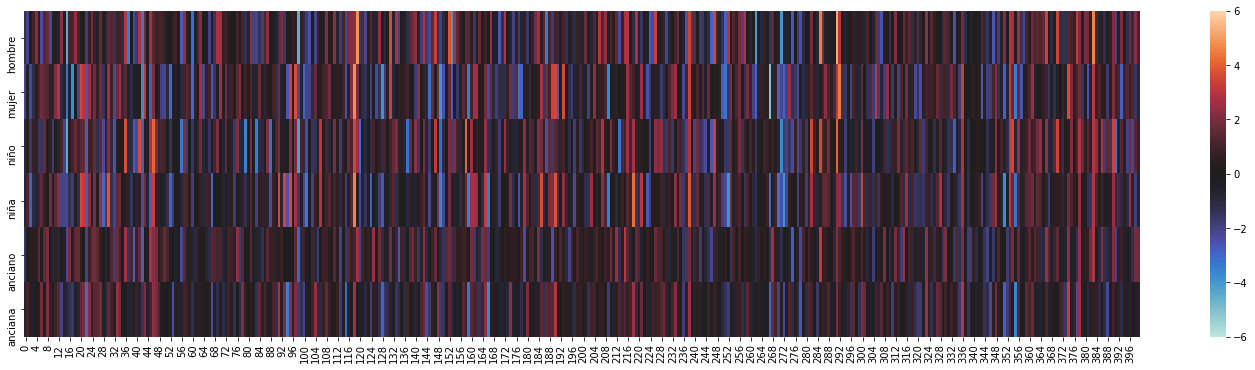

In [ ]:
#Visualización de los vectores de las palabas elegidas
fig = plt.figure(figsize = (25, 6))
ax = sns.heatmap(X, vmin = -6, vmax = 6,center = 0)

##Visualización de vectores en un espacio tridimensional

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pd.DataFrame(pca.fit_transform(X), index = X.index)
components.reset_index(inplace=True)


fig = px.scatter_3d( components, x=0, y=1, z=2, color='index',  
                    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
fig.show()

# Similitud entre vectores
[similitud coseno](https://en.wikipedia.org/wiki/Cosine_similarity)

## Similitud entre dos palabras

In [ ]:
def similitud_coseno(a_vector, b_vector):
    '''Calcula la similitud coseno entre los vectores a y b'''

    numerador = np.dot(a_vector, b_vector)
    
    a_norm = np.sqrt(np.sum(a_vector**2))  
    b_norm = np.sqrt(np.sum(b_vector**2))
    
    denominador = a_norm * b_norm
    
    similitud_coseno = numerador / denominador 
    
    return similitud_coseno

In [ ]:
similitud_coseno(w2v['computadora'], w2v['calculadora'])

0.528302

## Similitud de una palabra con palabras seleccionadas 

In [ ]:
def encuentra_similitudes(palabra, texto):
  lista = texto.split()
  lista.append(palabra)
  vectores = {}
  for p in lista:
    vectores[p] = w2v[p]
  X = pd.DataFrame.from_dict(vectores, orient='index')

  pca = PCA(n_components=3)
  components = pd.DataFrame(pca.fit_transform(X), index = X.index)
  components.reset_index(inplace=True)

  fig = px.scatter_3d( 
        components, x=0, y=1, z=2, color='index',
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
  fig.show()

  palabra_vec = X.loc[palabra, :]
  similitud={}
  for p in lista[:-1]:    # todas las palabras excepto la última
    p_vec = X.loc[p,:]
    similitud[p] = similitud_coseno(palabra_vec, p_vec)
  print(pd.Series(similitud).sort_values())


In [ ]:
encuentra_similitudes('perro', 'gato pájaro tiburón libélula lobo mariposa araña ardilla')

mariposa    0.172968
libélula    0.180578
araña       0.242797
ardilla     0.387270
tiburón     0.566994
pájaro      0.619912
lobo        0.683267
gato        0.852810
dtype: float64


## Seleccionar la palabra con mayor similitud

In [ ]:
def encuentra_palabra(a, b, c):
    a, b, c = a.lower(), b.lower(), c.lower()
    a_vector, b_vector, c_vector = w2v[a], w2v[b], w2v[c]

    max_similitud = -1000 #la inicializamos con una similaridad alejada
    mas_parecida = None
    
    for palabra in vocabulario:
        if palabra in [a, b, c]:
            continue
            
        sim_coseno = similitud_coseno(np.subtract(b_vector, a_vector), np.subtract(dic_word2vec[palabra], c_vector))
        
        if sim_coseno > max_similitud:
            max_similitud = sim_coseno
            mas_parecida = palabra
            
    return mas_parecida, sim_coseno

In [ ]:
%time encuentra_palabra('hombre', 'rey', 'mujer')

CPU times: user 1min 20s, sys: 1.71 s, total: 1min 22s
Wall time: 1min 20s


('reina', 0.20591584)

In [ ]:
%time w2v.most_similar(positive=['rey','mujer'],negative=['hombre'])

CPU times: user 507 ms, sys: 45.1 ms, total: 552 ms
Wall time: 315 ms


[('reina', 0.7011107802391052),
 ('princesa', 0.6539173126220703),
 ('emperatriz', 0.6132392883300781),
 ('esposa', 0.5980263948440552),
 ('doncella', 0.596245527267456),
 ('dama', 0.5885013341903687),
 ('infanta', 0.5754831433296204),
 ('concubina', 0.5528373122215271),
 ('hija', 0.5507358312606812),
 ('viuda', 0.538551390171051)]

In [ ]:
%time w2v.most_similar(positive=['día','blanco'],negative=['noche'])

CPU times: user 3.13 s, sys: 4.49 s, total: 7.62 s
Wall time: 7.42 s


[('negro', 0.5269008874893188),
 ('amarillo', 0.4956654906272888),
 ('blanco…', 0.49556422233581543),
 ('color', 0.4882056713104248),
 ('rojo', 0.4875211715698242),
 ('brochazo', 0.46383136510849),
 ('verde', 0.445975661277771),
 ('azul', 0.44447028636932373),
 ('dorado', 0.43204599618911743),
 ('lacito', 0.4297415316104889)]

In [ ]:
%time w2v.most_similar(positive=['francia','tokio'],negative=['paris'])

CPU times: user 509 ms, sys: 36.6 ms, total: 545 ms
Wall time: 290 ms


[('japón', 0.700680136680603),
 ('alemania', 0.6910410523414612),
 ('rusia', 0.6278168559074402),
 ('italia', 0.6217342615127563),
 ('españa', 0.6049107313156128),
 ('inglaterra', 0.5944952964782715),
 ('europa', 0.5936854481697083),
 ('china', 0.5927093625068665),
 ('polonia', 0.5785572528839111),
 ('moscú', 0.5745718479156494)]

In [ ]:
def encuentra_palabras_parecidas(palabra, n):
    palabra = palabra.lower()
    palabra_vector = dic_word2vec[palabra]
    
    max_similitud = -1000 #la inicializamos con una similaridad alejada
    mas_parecida = None
    
    similaridad ={}
    for p in vocabulario:
        if p is palabra:
            continue
            
        similaridad[p] = similitud_coseno(palabra_vector,dic_word2vec[p])
        
    similaridad_ordenada = {k:v for k,v in sorted(similaridad.items(),
                                                  key=lambda x: x[1],
                                                 reverse=True)}
    lista_palabras = list(similaridad_ordenada.keys())
            
    return lista_palabras[0:n]


In [ ]:
%time encuentra_palabras_parecidas('gato',15)

CPU times: user 1min 13s, sys: 1.86 s, total: 1min 15s
Wall time: 1min 13s


['gato',
 'perro',
 'gatito',
 'conejo',
 'ratón',
 'cachorro',
 'perrito',
 'zorro',
 'oso',
 'animalito',
 'tigre',
 'lagarto',
 'mapache',
 'perrillo',
 'animal']

In [ ]:
%time w2v.most_similar('gato')

CPU times: user 3.65 s, sys: 4.77 s, total: 8.42 s
Wall time: 1min 40s


[('perro', 0.8528096675872803),
 ('gatito', 0.81466144323349),
 ('conejo', 0.800269603729248),
 ('ratón', 0.7750607132911682),
 ('cachorro', 0.7548332214355469),
 ('perrito', 0.7415482401847839),
 ('zorro', 0.7346031665802002),
 ('oso', 0.7332919836044312),
 ('animalito', 0.7132523655891418),
 ('tigre', 0.7066872119903564)]

# Recursos

1. Almeida A. aitoralmeida/spanish_word2vec [Internet]. 2021 [citado 4 de mayo de 2021]. Disponible en: https://github.com/aitoralmeida/spanish_word2vec
2. Ganesan K. Easily Access Pre-trained Word Embeddings with Gensim [Internet]. Kavita Ganesan, Ph.D. 2019 [citado 4 de mayo de 2021]. Disponible en: https://kavita-ganesan.com/easily-access-pre-trained-word-embeddings-with-gensim/
3. Picture DS Nikhil Thorat, Charles Nicholson, Big. Embedding projector - visualization of high-dimensional data [Internet]. [citado 4 de mayo de 2021]. Disponible en: http://projector.tensorflow.org
4. Python | Word Embedding using Word2Vec [Internet]. GeeksforGeeks. 2018 [citado 4 de mayo de 2021]. Disponible en: https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
5. Alammar J. The Illustrated Word2vec [Internet]. [citado 4 de mayo de 2021]. Disponible en: http://jalammar.github.io/illustrated-word2vec/
([traduccido al español](https://tacosdedatos.com/word-to-vec-ilustrado))

